In [1]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

In [2]:
torch.__version__

'1.10.0'

In [3]:
data_path = 'D:\Repos\MLCS_Project_Assignments\\'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available else 'cpu')

In [5]:
training_params = {
    'device' : device,
    'batch_size' : 64,
    'num_epochs' : 5,
    'learning_rate' : 0.001
}

model_params = {
    'input_size': 28*28*1,
    'hidden_size' : [200, 160, 100, 80, 40],
    'out_size' : 10
}

In [6]:
mnist_training_dataset = datasets.MNIST(root=data_path+'train', train=True, download=True, transform=ToTensor())
mnist_testing_dataset = datasets.MNIST(root=data_path+'test', train=False, download=True, transform=ToTensor())

In [7]:
mask = int(len(mnist_training_dataset))

In [8]:
training_dataset, validation_dataset = random_split(mnist_training_dataset, [int(0.8*mask), int(0.2*mask)])

train_loader = DataLoader(training_dataset, batch_size=training_params['batch_size'], shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=training_params['batch_size'], shuffle=False)
test_loader = DataLoader(mnist_testing_dataset, batch_size=training_params['batch_size'], shuffle=False)

In [9]:
class ANN_Network(nn.Module):
    def __init__(self, model_parameters):
        try:
            super(ANN_Network, self).__init__()
            layers = []
            for in_channel, out_channel in zip([model_parameters['input_size']] + model_parameters['hidden_size'][:-1],
                                               model_parameters['hidden_size'][:len(model_parameters['hidden_size'])]):
                layers.append(nn.Linear(in_channel, out_channel, bias=True))
                layers.append(nn.ReLU())
            layers.append(nn.Linear( model_parameters['hidden_size'][-1], model_parameters['out_size'], bias=True))
            self.layers = nn.Sequential(*layers)
        
        except Exception as e:
            print('initializing failed due to ', e)
    
    def forward(self, x):
        try:
            return self.layers(x)
        
        except Exception as e:
            print('forward pass failed due to ', e)

In [10]:
model = ANN_Network(model_params).to(training_params['device'])
print(model.parameters)
total_params = sum(p.numel() for p in model.parameters())
print(total_params) ##### 216590

<bound method Module.parameters of ANN_Network(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=160, bias=True)
    (3): ReLU()
    (4): Linear(in_features=160, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=80, bias=True)
    (7): ReLU()
    (8): Linear(in_features=80, out_features=40, bias=True)
    (9): ReLU()
    (10): Linear(in_features=40, out_features=10, bias=True)
  )
)>
216990


In [11]:
criterion = nn.CrossEntropyLoss().to(training_params['device'])
optimizer = optim.Adam(model.parameters(), lr=training_params['learning_rate'])

In [12]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [13]:
train_loader.dataset.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: D:\Repos\MLCS_Project_Assignments\train
    Split: Train
    StandardTransform
Transform: ToTensor()

In [14]:
images, targets = next(iter(train_loader))
images.shape #### batch of 64 images about 28x28 pixels in grayscale 

torch.Size([64, 1, 28, 28])

In [17]:
best_accuracy = -1
train_acc_history = []
validation_acc_history = []
    
for epoch in range(training_params['num_epochs']):
    
    model.train()
    correct_predictions = 0
    loss_values = []
    train_acc_scores = []

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.view(images.shape[0], -1).to(training_params['device'])
        targets = targets.to(training_params['device'])

        outputs = model(images)
        loss = criterion(outputs, targets)
        loss_values.append(loss.item())
        
        _, preds = torch.max(outputs, 1)
        correct_predictions=(preds==targets).sum().item()
        train_acc_scores.append(correct_predictions/targets.shape[0])
                      
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 100 == 0:
            print (f'Epoch {epoch+1} | Step [{batch_idx+1}/{len(train_loader)}] | Loss: {loss.item()} ')

    train_acc_history.append((sum(train_acc_scores)/len(train_acc_scores))*100)
    print(f'Epoch {epoch+1} | Loss: {(sum(loss_values)/len(loss_values))} | Training Accuracy {train_acc_history[-1]}%')
    
    model.eval()
    with torch.no_grad():
        correct_predictions = 0
        validation_acc_scores = []
        
        for images, targets in iter(validation_loader):
            images = images.view(images.shape[0], -1).to(training_params['device'])
            targets = targets.to(training_params['device'])
            
            outputs = model(images)
            
            _, preds = torch.max(outputs, 1)
            correct_predictions = (preds == targets).sum().item()
            validation_acc_scores.append(correct_predictions/targets.shape[0])
            
        validation_acc_history.append((sum(validation_acc_scores)/len(validation_acc_scores))*100)
        print(f'Epoch {epoch+1} | Validation Accuracy {validation_acc_history[-1]}%')
        
        if validation_acc_history[-1]>best_accuracy:
            best_accuracy = validation_acc_history[-1]
            print('Saving the model...')
            torch.save(model.state_dict(), f"Accuracy_{best_accuracy}_batchsize_{training_params['batch_size']}_lr_{training_params['learning_rate']}.ckpt")

Epoch 1 | Step [100/750] | Loss: 0.07790975272655487 
Epoch 1 | Step [200/750] | Loss: 0.001050796010531485 
Epoch 1 | Step [300/750] | Loss: 0.05385412275791168 
Epoch 1 | Step [400/750] | Loss: 0.0038906780537217855 
Epoch 1 | Step [500/750] | Loss: 0.07374375313520432 
Epoch 1 | Step [600/750] | Loss: 0.04110896959900856 
Epoch 1 | Step [700/750] | Loss: 0.03730782866477966 
Epoch 1 | Loss: 0.04228732976821872 | Training Accuracy 98.70208333333333%
Epoch 1 | Validation Accuracy 96.8999335106383%
Saving the model...
Epoch 2 | Step [100/750] | Loss: 0.04256628081202507 
Epoch 2 | Step [200/750] | Loss: 0.026473557576537132 
Epoch 2 | Step [300/750] | Loss: 0.004412641283124685 
Epoch 2 | Step [400/750] | Loss: 0.00045268330723047256 
Epoch 2 | Step [500/750] | Loss: 0.04834429547190666 
Epoch 2 | Step [600/750] | Loss: 0.006312614306807518 
Epoch 2 | Step [700/750] | Loss: 0.01218470185995102 
Epoch 2 | Loss: 0.03762824650745218 | Training Accuracy 98.85208333333333%
Epoch 2 | Validat

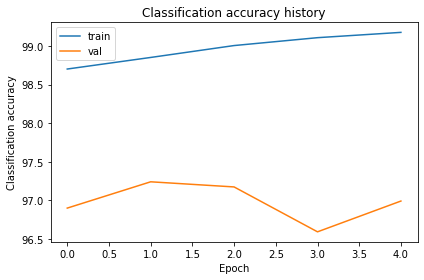

In [20]:

plt.plot(train_acc_history, label='train')
plt.plot(validation_acc_history, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: D:\Repos\MLCS_Project_Assignments\test
    Split: Test
    StandardTransform
Transform: ToTensor()

In [23]:
model.load_state_dict(torch.load("Accuracy_97.91389627659575_batchsize_64_lr_0.001.ckpt"))

with torch.no_grad():
    correct_predictions = 0
    test_images = 0
    testing_acc_history = []

    for images, targets in iter(test_loader):
        images = images.view(images.shape[0], -1).to(training_params['device'])
        targets = targets.to(training_params['device'])
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_predictions = (preds==targets).sum().item()
        test_images += targets.shape[0]
        testing_acc_history.append(correct_predictions/targets.shape[0])
    
    print(f'Accuracy of the network on the {test_images} test images: {(sum(testing_acc_history)/len(testing_acc_history))*100}')

Accuracy of the network on the 10000 test images: 98.218550955414
